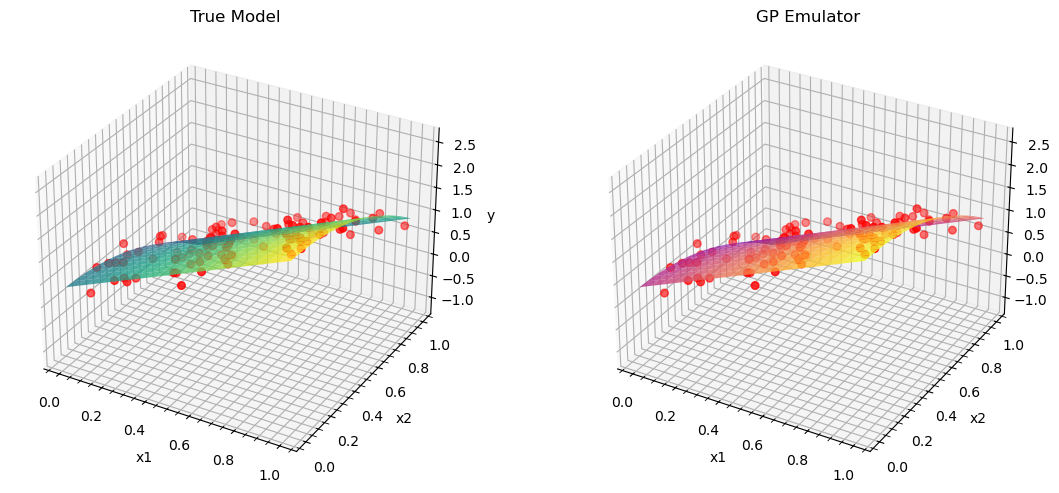

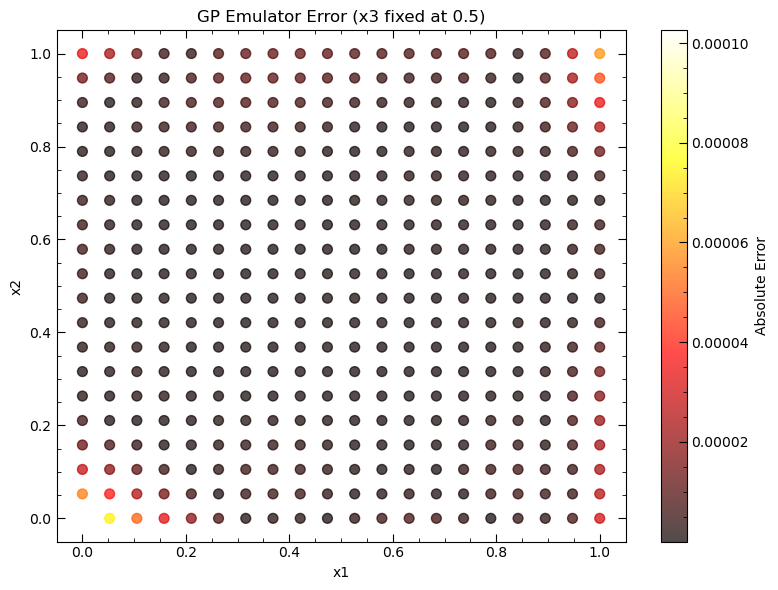

Matrix not positive definite, skipping this iteration
Floating point error in optimization routine, skipping this iteration


In [60]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import emcee
from scipy.optimize import minimize

import mogp_emulator
from mogp_emulator.Kernel import SquaredExponential

# --- Define the true function ---
def true_function(xyz, a=2.0, b=-1.5, c=0.8):
    x, y, z = xyz[..., 0], xyz[..., 1], xyz[..., 2]
    return a * x + b * y**2 + c * np.sin(z)

# --- Generate training data ---
n_train = 100
bounds = [(0.0, 1.0)] * 3  # 3D unit cube
n_params = 3
design = mogp_emulator.LatinHypercubeDesign(n_params, bounds)
X_train = design.sample(n_train)
Y_train = true_function(X_train)
# --- Visualize the data and model ---
# Generate test points in a grid for visualization
n_grid = 20
x1_grid = np.linspace(0, 1, n_grid)
x2_grid = np.linspace(0, 1, n_grid)
X1, X2 = np.meshgrid(x1_grid, x2_grid)

# Choose a fixed value for x3 
x3_fixed = 0.5

# Create grid points for visualization
grid_points = np.column_stack((X1.ravel(), X2.ravel(), np.ones(X1.size) * x3_fixed))

# Calculate true model values at grid points
true_values = true_function(grid_points)

# Get GP predictions at grid points
grid_df = pd.DataFrame(grid_points, columns=["x1", "x2", "x3"]).astype(np.float64)
emulator_values = list(gp.predict(grid_df).values())[0]

# Plot true vs emulated model
fig, axes = plt.subplots(1, 2, figsize=(12, 5), subplot_kw={'projection': '3d'})

# True model
axes[0].plot_surface(X1, X2, true_values.reshape(n_grid, n_grid), cmap='viridis', alpha=0.8)
axes[0].scatter(X_train[:, 0], X_train[:, 1], Y_train, c='r', marker='o', s=30)
axes[0].set_title('True Model')
axes[0].set_xlabel('x1')
axes[0].set_ylabel('x2')
axes[0].set_zlabel('y')

# Emulated model
axes[1].plot_surface(X1, X2, emulator_values.reshape(n_grid, n_grid), cmap='plasma', alpha=0.8)
axes[1].scatter(X_train[:, 0], X_train[:, 1], Y_train, c='r', marker='o', s=30)
axes[1].set_title('GP Emulator')
axes[1].set_xlabel('x1')
axes[1].set_ylabel('x2')
axes[1].set_zlabel('y')

plt.tight_layout()
plt.show()

# Calculate and plot errors
errors = np.abs(true_values - emulator_values)
plt.figure(figsize=(8, 6))
plt.scatter(grid_points[:, 0], grid_points[:, 1], c=errors, cmap='hot', s=50, alpha=0.7)
plt.colorbar(label='Absolute Error')
plt.title(f'GP Emulator Error (x3 fixed at {x3_fixed})')
plt.xlabel('x1')
plt.ylabel('x2')
plt.tight_layout()
plt.show()
# Convert to DataFrame with float64 dtype for GP compatibility
X_df = pd.DataFrame(X_train, columns=["x1", "x2", "x3"]).astype(np.float64)

# --- Train the GP emulator ---
kernel = SquaredExponential()
gp = mogp_emulator.GaussianProcess(X_df, Y_train)

gp=mogp_emulator.fit_GP_MAP(gp)

# --- MCMC setup ---
def log_likelihood(theta, X, Y, error=0.01):
    a, b, c = theta
    model = a * X[:, 0] + b * X[:, 1]**2 + c * np.sin(X[:, 2])
    return -0.5 * np.sum(((Y - model) / error) ** 2)

def log_prior(theta):
    a, b, c = theta
    if -10 < a < 10 and -10 < b < 10 and -10 < c < 10:
        return 0.0
    return -np.inf

def log_probability(theta, X, Y, error=0.01):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, X, Y, error)


In [57]:
# --- Run MCMC with true model ---
n_walkers = 32
n_steps = 500
init_pos = [np.array([1.5, -1.0, 1.0]) + 1e-2 * np.random.randn(3) for _ in range(n_walkers)]

sampler = emcee.EnsembleSampler(n_walkers, 3, log_probability, args=(X_train, Y_train))

start_true = time.time()
sampler.run_mcmc(init_pos, n_steps, progress=True)
end_true = time.time()

# --- Run MCMC with GP emulator ---
def emulator_log_likelihood(theta, gp_model, X):
    a, b, c = theta
    model_vals = a * X[:, 0] + b * X[:, 1]**2 + c * np.sin(X[:, 2])

    pred_vals = list(gp_model.predict(pd.DataFrame(X, columns=["x1", "x2", "x3"]).astype(np.float64)).values())[0]

    return -0.5 * np.sum((pred_vals - model_vals) ** 2 / 0.01 ** 2)


def emulator_log_probability(theta, gp_model, X):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + emulator_log_likelihood(theta, gp_model, X)

sampler_gp = emcee.EnsembleSampler(n_walkers, 3, emulator_log_probability, args=(gp, X_train))

start_gp = time.time()
sampler_gp.run_mcmc(init_pos, n_steps, progress=True)
end_gp = time.time()

# --- Print time results ---
print(f"\nTime with true model:     {end_true - start_true:.2f} seconds")
print(f"Time with GP emulator:    {end_gp - start_gp:.2f} seconds")


You must install the tqdm library to use progress indicators with emcee
You must install the tqdm library to use progress indicators with emcee



Time with true model:     0.63 seconds
Time with GP emulator:    9.43 seconds



True model MCMC results (median ± 1σ):
  a = 2.000 (+0.003, -0.003)
  b = -1.500 (+0.003, -0.003)
  c = 0.800 (+0.003, -0.003)

GP emulator MCMC results (median ± 1σ):
  a = 2.000 (+0.003, -0.003)
  b = -1.500 (+0.003, -0.003)
  c = 0.800 (+0.003, -0.003)


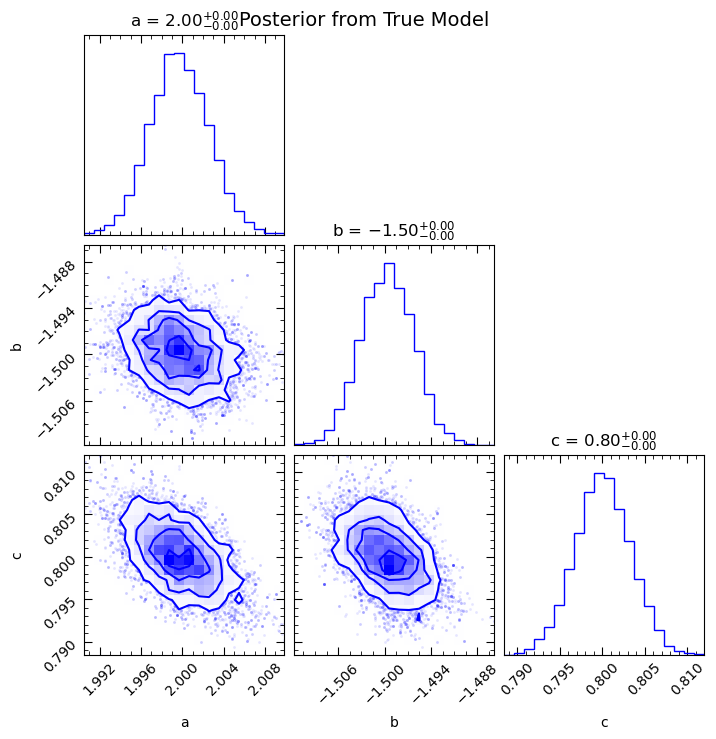

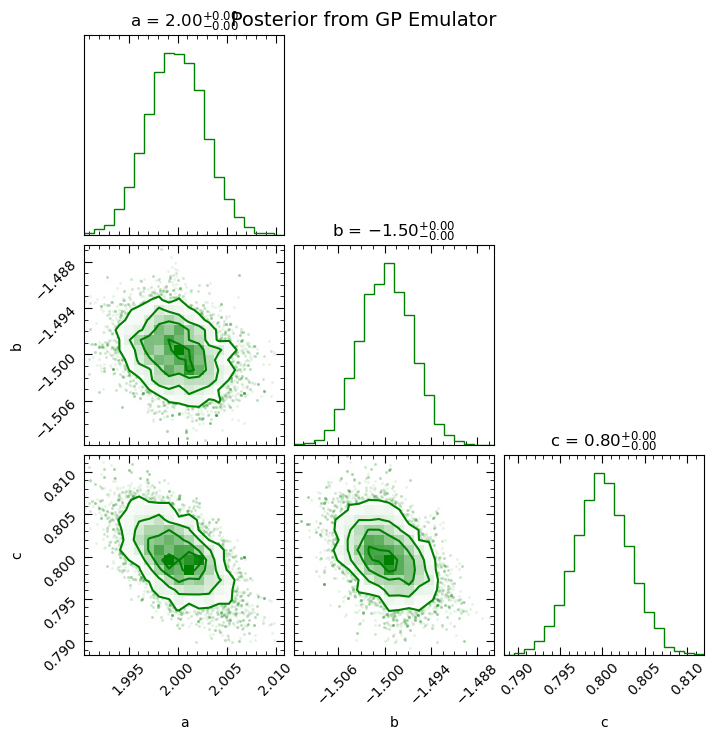

In [55]:
import corner

# Get the MCMC samples (discard burn-in)
burnin = 100
samples_true = sampler.get_chain(discard=burnin, flat=True)
samples_gp = sampler_gp.get_chain(discard=burnin, flat=True)

# Print median + 1-sigma credible intervals
def print_summary(samples, label):
    med = np.median(samples, axis=0)
    err_lower = np.percentile(samples, 16, axis=0)
    err_upper = np.percentile(samples, 84, axis=0)
    print(f"\n{label} MCMC results (median ± 1σ):")
    for i, param in enumerate(["a", "b", "c"]):
        print(f"  {param} = {med[i]:.3f} (+{err_upper[i]-med[i]:.3f}, -{med[i]-err_lower[i]:.3f})")

print_summary(samples_true, "True model")
print_summary(samples_gp, "GP emulator")

# Plot corner plots side by side
fig1 = corner.corner(samples_true, labels=["a", "b", "c"], color="blue", show_titles=True)
fig1.suptitle("Posterior from True Model", fontsize=14)

fig2 = corner.corner(samples_gp, labels=["a", "b", "c"], color="green", show_titles=True)
fig2.suptitle("Posterior from GP Emulator", fontsize=14)

plt.show()


In [2]:
from astropy.table import Table

# Read the FITS file into an astropy Table
fits_file_path = "../C23_models/z_0_model.fits"
model_table = Table.read(fits_file_path)

# Display basic information about the table
print(f"Number of rows: {len(model_table)}")
print("\nColumn names:", model_table.colnames)
print(f"Number of columns: {len(model_table.colnames)}")
# Show a few rows of the table
print("\nFirst 5 rows of the table:")
print(model_table[:5])

Number of rows: 19437

Column names: ['H', 'H+', 'H-', 'H2', 'H2*', 'H2+', 'H3+', 'He', 'He+', 'He+2', 'HeH+', 'Li', 'Li+', 'Li+2', 'Li+3', 'Li-', 'LiH', 'LiH+', 'C', 'C+', 'C+2', 'C+3', 'C+4', 'C+5', 'C+6', 'CH', 'CH+', 'CH2', 'CH2+', 'CH3', 'CH3+', 'CH4', 'CH4+', 'CH5+', 'C2', 'C2+', 'C2H', 'C2H+', 'C2H2', 'C2H2+', 'C2H3+', 'C3', 'C3+', 'C3H', 'C3H+', 'N', 'N+', 'N+2', 'N+3', 'N+4', 'N+5', 'N+6', 'N+7', 'NH', 'NH+', 'NH2', 'NH2+', 'NH3', 'NH3+', 'NH4+', 'CN', 'CN+', 'HCN', 'HCN+', 'HNC', 'HCNH+', 'HC3N', 'N2', 'N2+', 'N2H+', 'O', 'O+', 'O+2', 'O+3', 'O+4', 'O+5', 'O+6', 'O+7', 'O+8', 'OH', 'OH+', 'H2O', 'H2O+', 'H3O+', 'CO', 'CO+', 'HCO+', 'H2CO', 'CH3OH', '^13CO', 'NO', 'NO+', 'HNO', 'HNO+', 'OCN', 'OCN+', 'N2O', 'O2', 'O2+', 'NO2', 'NO2+', 'Ne', 'Ne+', 'Ne+10', 'Ne+2', 'Ne+3', 'Ne+4', 'Ne+5', 'Ne+6', 'Ne+7', 'Ne+8', 'Ne+9', 'NeH+', 'Na', 'Na+', 'Na+10', 'Na+11', 'Na+2', 'Na+3', 'Na+4', 'Na+5', 'Na+6', 'Na+7', 'Na+8', 'Na+9', 'Mg', 'Mg+', 'Mg+10', 'Mg+11', 'Mg+12', 'Mg+2', 'Mg+3', '

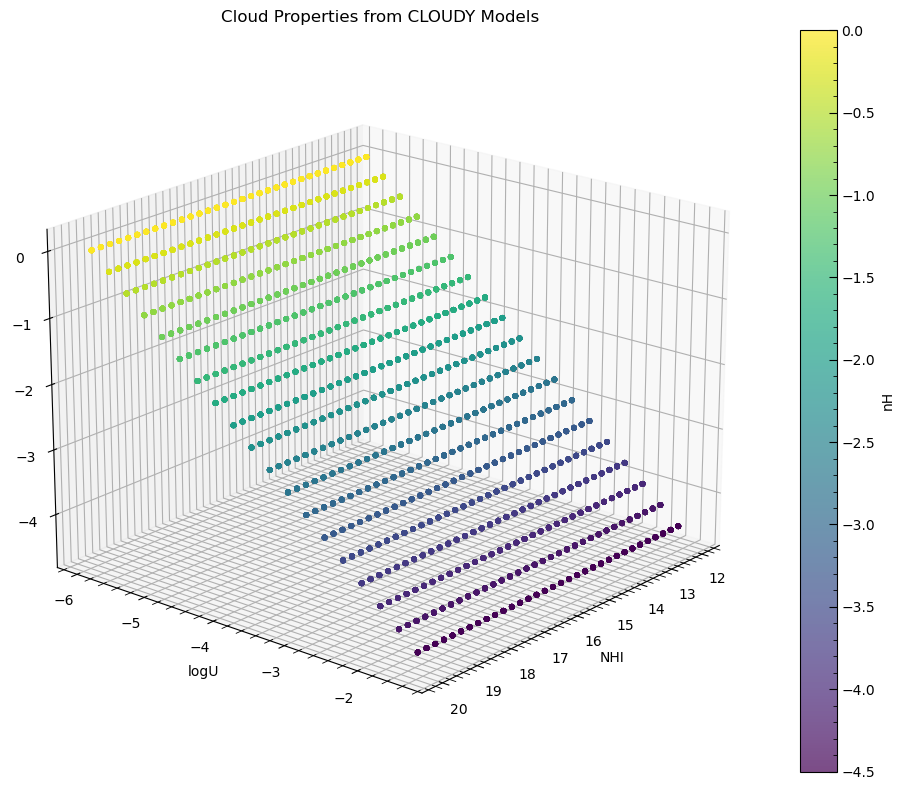

In [69]:
# Create a 3D scatter plot to visualize the model data
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points with NHI, logU, and nH
scatter = ax.scatter(model_table["NHI"], model_table["logU"], model_table["nH"], 
                    c=model_table["nH"], # Use nH for color
                    cmap='viridis', 
                    s=10, # point size
                    alpha=0.7)

# Add labels and title
ax.set_xlabel('NHI')
ax.set_ylabel('logU')
ax.set_zlabel('nH')
ax.set_title('Cloud Properties from CLOUDY Models')

# Rotate view to be more parallel to logU axis (90 degrees clockwise)
ax.view_init(elev=20, azim=40)  # Set elevation and azimuth for the view

# Add a colorbar
cbar = plt.colorbar(scatter)
cbar.set_label('nH')

plt.tight_layout()
plt.show()